In [1]:
##########
# transform image
#########

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tifffile
import cv2

# Step 1: Load the transformation matrix from the CSV file

csv_file_path = "/project/simmons_hts/kxu/hest/xenium_labelled/metadata/XeniumPR1S1ROI1_STalign_to_HE_matrix.csv" # Update this with the path to your CSV file
transformation_matrix_df = pd.read_csv(csv_file_path, header=None)
transformation_matrix = transformation_matrix_df.to_numpy()

# Verify the transformation matrix
print("Transformation Matrix:")
print(transformation_matrix)

# Step 2: Extract the affine transformation matrix (2x3) for OpenCV
affine_matrix = transformation_matrix[:2, :]  # Use only the first two rows for affine transformation

# Step 3: Load the OME-TIFF image
image_path = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE.ome.tif"  # Update with the path to your OME-TIFF image
image = tifffile.imread(image_path)

# Verify the image shape and data type
print("Image shape:", image.shape)
print("Image dtype:", image.dtype)

# Step 4: Adjust the output canvas size
# Calculate bounds of the transformed image
height, width = image.shape[:2]
corners = np.array([
    [0, 0, 1],
    [width, 0, 1],
    [0, height, 1],
    [width, height, 1]
])
transformed_corners = (transformation_matrix @ corners.T).T
x_min, y_min = transformed_corners[:, 0].min(), transformed_corners[:, 1].min()
x_max, y_max = transformed_corners[:, 0].max(), transformed_corners[:, 1].max()

# Calculate new width and height
new_width = int(x_max - x_min)
new_height = int(y_max - y_min)

# Adjust the affine matrix to account for translation
adjusted_affine_matrix = affine_matrix.copy()
adjusted_affine_matrix[0, 2] -= x_min
adjusted_affine_matrix[1, 2] -= y_min

# Step 5: Apply the affine transformation
# Apply the transformation with the new canvas size
transformed_image = cv2.warpAffine(image, adjusted_affine_matrix, (new_width, new_height))

# Step 6: Save the transformed image
output_path = "/project/simmons_hts/kxu/hest/xenium_labelled/aligned_image/CAM006_Xenium5K_post_HnE_transformed.ome.tif"  # Path to save the transformed image
tifffile.imwrite(output_path, transformed_image)

print(f"Transformed image saved to {output_path}")

Transformation Matrix:
[[ 2.14998311e-01  2.31060083e+00 -9.44639624e+03]
 [ 2.33973648e+00  7.33092739e-02  6.52626867e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Image shape: (8585, 8851, 3)
Image dtype: uint8
Transformed image saved to /project/simmons_hts/kxu/hest/xenium_labelled/aligned_image/CAM006_Xenium5K_post_HnE_transformed.ome.tif


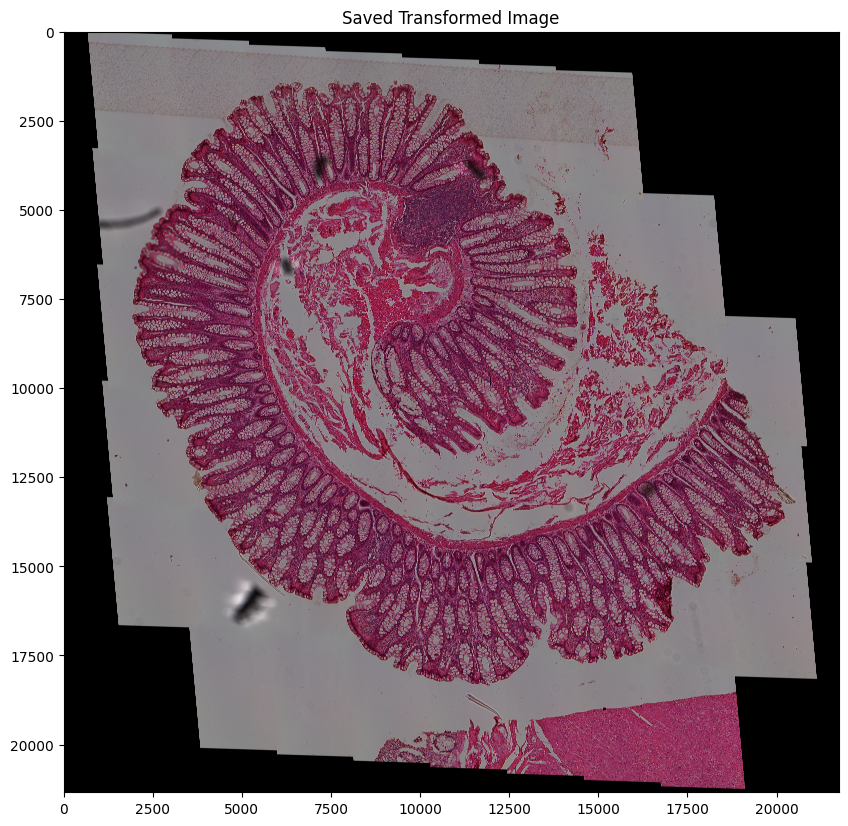

In [2]:
saved_image = tifffile.imread(output_path)
plt.figure(figsize=(10, 10))
plt.imshow(saved_image, cmap='gray')
plt.title("Saved Transformed Image")
#plt.axis("off")
plt.show()


In [3]:
import pandas as pd
import numpy as np
import tifffile
import cv2

# Load the transformation matrix from the CSV file
csv_file_path = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE_matrix.csv"
transformation_matrix_df = pd.read_csv(csv_file_path, header=None)
transformation_matrix = transformation_matrix_df.to_numpy()

# Extract the affine transformation matrix (2x3)
affine_matrix = transformation_matrix[:2, :]

# Load the source and target images
source_image_path = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE.ome.tif"
target_image_path = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/SLIDE1/ROI1.explorer/morphology.ome.tif"

source_image = tifffile.imread(source_image_path)
target_image = tifffile.imread(target_image_path)

# Extract dimensions
src_height, src_width = source_image.shape[:2]
tgt_height, tgt_width = target_image.shape[1:3]  # Ignore depth for canvas size

# Debugging: Print transformation parameters
print("Transformation Matrix:")
print(transformation_matrix)
print("Source Image shape:", source_image.shape)
print("Target Image shape:", target_image.shape)

# Calculate transformed corners of the source image
corners = np.array([
    [0, 0, 1],
    [src_width, 0, 1],
    [0, src_height, 1],
    [src_width, src_height, 1]
])
transformed_corners = (transformation_matrix @ corners.T).T
print("Transformed Corners (before adjustment):")
print(transformed_corners)

# Adjust the affine matrix for centering in the target canvas
x_min, y_min = transformed_corners[:, 0].min(), transformed_corners[:, 1].min()
adjusted_affine_matrix = affine_matrix.copy()
adjusted_affine_matrix[0, 2] -= x_min
adjusted_affine_matrix[1, 2] -= y_min

# Transform the source image to match the target dimensions
transformed_image = cv2.warpAffine(
    source_image, 
    adjusted_affine_matrix, 
    (tgt_width, tgt_height)
)

# Save the transformed image
output_path = "/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE_transformed.ome.tif"
tifffile.imwrite(output_path, transformed_image)

print("Transformed image saved to", output_path)

Transformation Matrix:
[[ 7.56913371e-02  2.04731417e+00  1.82325164e+04]
 [ 2.04731417e+00 -7.56913371e-02 -2.20192990e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Source Image shape: (8585, 8851, 3)
Target Image shape: (5, 108912, 54237)
Transformed Corners (before adjustment):
[[ 1.82325164e+04 -2.20192990e+03  1.00000000e+00]
 [ 1.89024604e+04  1.59188478e+04  1.00000000e+00]
 [ 3.58087085e+04 -2.85174003e+03  1.00000000e+00]
 [ 3.64786526e+04  1.52690377e+04  1.00000000e+00]]


PermissionError: [Errno 13] Permission denied: '/ceph/project/simmons_hts/jpark/1_project/0_xenium/RUNTRexBio/post_HnE/CAM006_Xenium5K_post_HnE_transformed.ome.tif'

In [ ]:
from matplotlib import pyplot as plt

saved_image = tifffile.imread(output_path)
plt.figure(figsize=(10, 10))
plt.imshow(saved_image, cmap='gray')
plt.title("Saved Transformed Image")
plt.axis("off")
plt.show()
